# Лабораторная работа №3

In [1]:
# !pip install torch-scatter
# !pip install torch_geometric
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

import os
import torch

from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from torch import Tensor, nn
from torch_geometric.nn import GCNConv

import pandas as pd
from tqdm import tqdm
import numpy as np

from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from itertools import product

import math


os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.5.0+cu121


In [2]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

 # Найти графовый набор данных для решения задачи предсказания (классификация вершин, обнаружение сообществ и т.д.).

In [3]:
dataset = Planetoid(root='data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')



Dataset: CiteSeer():
Number of graphs: 1
Number of features: 3703
Number of classes: 6

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])
Number of nodes: 3327
Number of edges: 9104
Average node degree: 2.74
Number of training nodes: 120
Training node label rate: 0.04
Has isolated nodes: True
Has self-loops: False
Is undirected: True


# Использовать несколько слоев GCNConv из библиотеки PyG для построения GCN модели.

In [4]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels1, hidden_channels2):
        super().__init__()
        torch.manual_seed(0)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels1)
        self.conv2 = GCNConv(hidden_channels1, hidden_channels2)
        self.conv3 = GCNConv(hidden_channels2, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index)
        return x

model1 = GCN(hidden_channels1 = 32, hidden_channels2 = 64)
print(model1)

GCN(
  (conv1): GCNConv(3703, 32)
  (conv2): GCNConv(32, 64)
  (conv3): GCNConv(64, 6)
)



# Обучить полученную модель, подобрать гиперпараметры (например, learning rate) на валидационной выборке, и оценить качество предсказания на тестовой выборке.

In [5]:
'''Перебираемые параметры'''
lr = [0.1, 0.01, 0.001]
weight_decay = [5e-3, 5e-4, 5e-5]
num_epochs = 100
criterion = torch.nn.CrossEntropyLoss()

In [6]:
'''Функции для тренировки, валидации и тестирования модели'''
def train(data, model, optimizer, criterion):
	model.train()
	optimizer.zero_grad()  # Clear gradients.
	out = model(data.x, data.edge_index)  # Perform a single forward pass.
	loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
	loss.backward()  # Derive gradients.
	optimizer.step()  # Update parameters based on gradients.
	return loss

def validate(data, model):
  model.eval()
  out = model(data.x, data.edge_index)
  val_pred = out.argmax(dim=1)  # Use the class with highest probability.
  test_correct = val_pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
  test_acc = int(test_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
  return test_acc

def test(data, model):
	model.eval()
	out = model(data.x, data.edge_index)
	pred = out.argmax(dim=1)  # Use the class with highest probability.
	test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
	test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
	return test_acc

In [7]:
'''Непосредственно перебор'''
results = {}
for w_decay, lrate in product(weight_decay, lr):
    model = GCN(hidden_channels1=32, hidden_channels2=16)
    optimizer = Adam(model.parameters(), lr=lrate, weight_decay=w_decay)

    # Обучение модели
    for epoch in range(num_epochs):
        loss = train(data, model, optimizer, criterion)

    # Валидация
    val_acc = validate(data, model)
    test_acc = test(data, model)

    # Сохранение результатов
    params = f"weight_decay={w_decay}, lr={lrate}"
    results[params] = {
        "validation_accuracy": val_acc,
        "test_accuracy": test_acc,
        "final_loss": loss.item()
    }
    print(f"{params} \t\t val accuracy: {val_acc:.4f}, test accuracy: {test_acc:.4f}")

# Печать лучших результатов
best_params = max(results, key=lambda k: results[k]["validation_accuracy"])
print("\nBest:")
print(best_params)
print("Results:", results[best_params])

weight_decay=0.005, lr=0.1 		 val accuracy: 0.4400, test accuracy: 0.4310
weight_decay=0.005, lr=0.01 		 val accuracy: 0.4240, test accuracy: 0.4090
weight_decay=0.005, lr=0.001 		 val accuracy: 0.4380, test accuracy: 0.4150
weight_decay=0.0005, lr=0.1 		 val accuracy: 0.6240, test accuracy: 0.6140
weight_decay=0.0005, lr=0.01 		 val accuracy: 0.6620, test accuracy: 0.6610
weight_decay=0.0005, lr=0.001 		 val accuracy: 0.5420, test accuracy: 0.5240
weight_decay=5e-05, lr=0.1 		 val accuracy: 0.6460, test accuracy: 0.6350
weight_decay=5e-05, lr=0.01 		 val accuracy: 0.6640, test accuracy: 0.6600
weight_decay=5e-05, lr=0.001 		 val accuracy: 0.4920, test accuracy: 0.4850

Best:
weight_decay=5e-05, lr=0.01
Results: {'validation_accuracy': 0.664, 'test_accuracy': 0.66, 'final_loss': 0.023460090160369873}


100%|██████████| 201/201 [00:11<00:00, 17.47it/s]


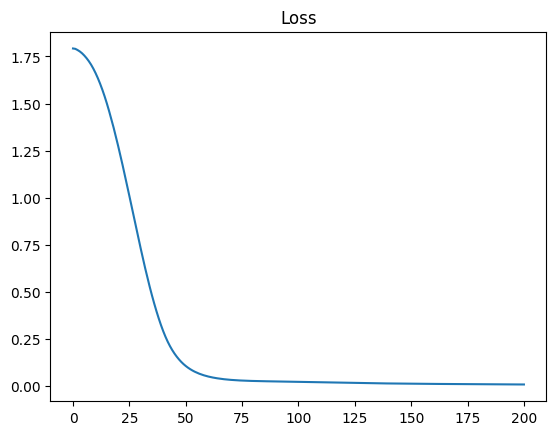

Val accuracy: 0.6680
Test accuracy: 0.6680


In [8]:
'''еще раз модель с лучшими гиперпараметрами'''
best_lr, best_weight_decay = 0.01, 5e-5
criterion = torch.nn.CrossEntropyLoss()
model = GCN(hidden_channels1=32, hidden_channels2=16)
optimizer = Adam(model.parameters(), lr=best_lr, weight_decay=best_weight_decay)

losses = []
for epoch in tqdm(range(0,201)):
	loss = train(data, model, optimizer, criterion)
	losses.append(loss.item())

'''Визуализация обучения'''
plt.plot(np.arange(len(losses)), losses)
plt.title('Loss')
plt.show()


'''accuracy на валидационной и тестовой выборках'''
val_acc = validate(data, model)
test_acc = test(data, model)
print(f'Val accuracy: {val_acc:.4f}')
print(f'Test accuracy: {val_acc:.4f}')

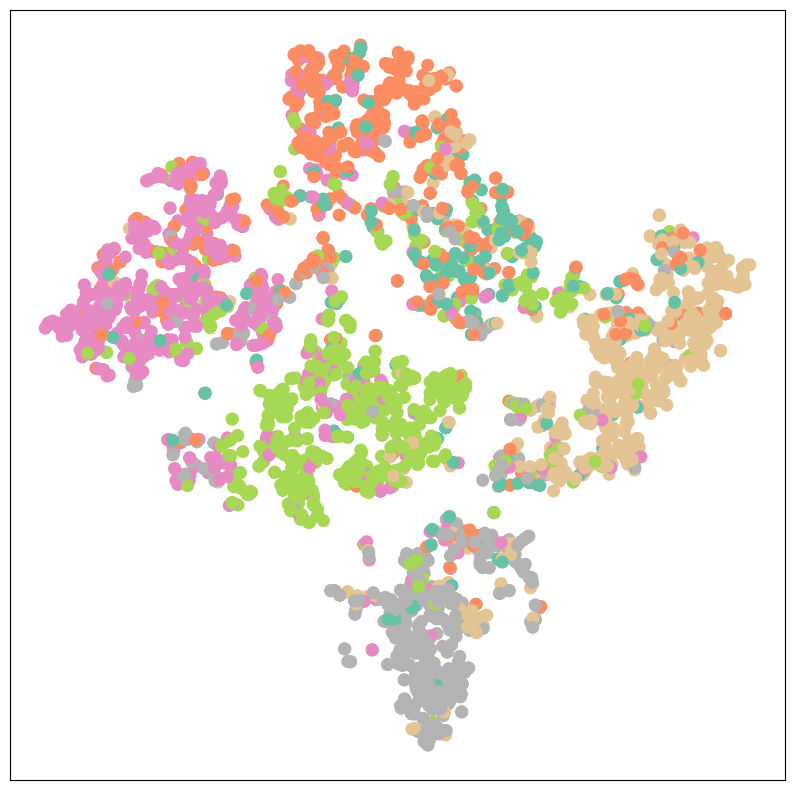

In [9]:
'''Визуализация графа после обучения модели'''
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

**Комментарий**:
Видим, что наблюдается несколько неплохо разделимых классов, но часть точек внутри них ошибочно классифицированы.





 # (+5 баллов) Также представить самостоятельную реализацию слоя GCNConv, используя матричные операции. Повторить обучение с собственными слоями и сравнить результаты.

In [10]:
class myGCNConvLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        # инициализация весов и смещений
        self.W = nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.bias = nn.Parameter(torch.FloatTensor(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.W, a=math.sqrt(5))
        nn.init.zeros_(self.bias)

    def self_loops_adder(self, edge_index, num_nodes):
        ###### Добавление self-loops в граф
        self_loops = torch.arange(0, num_nodes, dtype=torch.long, device=edge_index.device)
        self_loops = self_loops.unsqueeze(0).repeat(2, 1)
        return torch.cat([edge_index, self_loops], dim=1)

    def adjacency_matrix_normalizer(self, edge_index, num_nodes):
        ###### Нормализация матрицы смежности в формате edge_index
        # Степени узлов
        row, col = edge_index
        deg = torch.bincount(row, minlength=num_nodes)
        deg_inv_sqrt = torch.pow(deg, -0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0.0

        # Нормализация ребер
        values = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        return edge_index, values

    def forward(self, X, edge_index):
        num_nodes = X.size(0)
        edge_index = self.self_loops_adder(edge_index, num_nodes) # Добавление self-loops
        edge_index, edge_weight = self.adjacency_matrix_normalizer(edge_index, num_nodes) # Нормализация

        # Применение нормализованного Лапласиана: A_hat @ X @ W + b
        X = torch.mm(X, self.W)
        output = self.propagate(X, edge_index, edge_weight)
        return output + self.bias

    def propagate(self, X, edge_index, edge_weight):
        row, col = edge_index
        out = torch.zeros_like(X)
        out.index_add_(0, row, X[col] * edge_weight.unsqueeze(1))
        return out


In [11]:
'''Создаем модель, но уже используем не GCN из библиотеки, а собственный'''
class GCN1(torch.nn.Module):
    def __init__(self, hidden_channels1, hidden_channels2):
        super().__init__()
        torch.manual_seed(0)
        self.conv1 = myGCNConvLayer(dataset.num_features, hidden_channels1)
        self.conv2 = myGCNConvLayer(hidden_channels1, hidden_channels2)
        self.conv3 = myGCNConvLayer(hidden_channels2, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index)
        return x

model2 = GCN1(hidden_channels1=32, hidden_channels2=64)

100%|██████████| 201/201 [00:13<00:00, 15.32it/s]


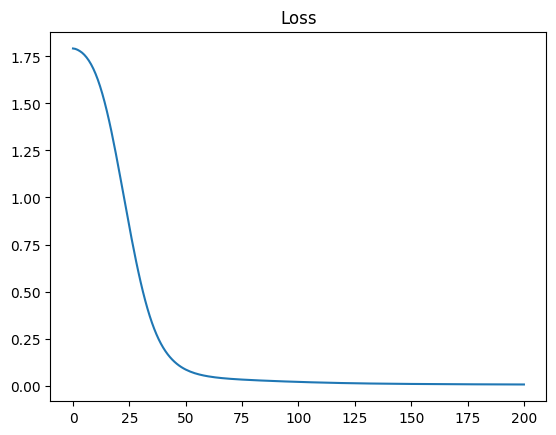

Val accuracy: 0.6800
Test accuracy: 0.6800


In [12]:
'''еще раз модель с лучшими гиперпараметрами'''
best_lr, best_weight_decay = 0.01, 5e-5
criterion = torch.nn.CrossEntropyLoss()
model = GCN1(hidden_channels1=32, hidden_channels2=16)
optimizer = Adam(model.parameters(), lr=best_lr, weight_decay=best_weight_decay)

losses = []
for epoch in tqdm(range(0,201)):
	loss = train(data, model, optimizer, criterion)
	losses.append(loss.item())

'''Визуализация обучения'''
plt.plot(np.arange(len(losses)), losses)
plt.title('Loss')
plt.show()


'''accuracy на валидационной и тестовой выборках'''
val_acc = validate(data, model)
test_acc = test(data, model)
print(f'Val accuracy: {val_acc:.4f}')
print(f'Test accuracy: {val_acc:.4f}')

# Вывод

Модель с собственным разработанным слоем GCN работает чуть-чуть медленнее, но не сильно. Графики значений loss-функции во время обучения у моделей схожи, значения метрики accuracy тоже. Отсюда можно заключить, что успешно удалось воссоздать GCN слой.
